In [ ]:
from dotenv import load_dotenv
import os
import pandas as pd
import ccxt
import pandas_ta as ta
import decimal
import time

load_dotenv()

True

In [2]:
binance_api_key = os.getenv("BINANCE_API_KEY")
binance_api_secret = os.getenv("BINANCE_API_SECRET")

In [25]:
binance = ccxt.binance({
    "enableRateLimit": True,
    "options": {
        "defaultType": "future"
    },
    "apiKey": binance_api_key,
    "secret": binance_api_secret,
})

symbols = ["XRPUSDT"]
bal = binance.fetch_positions(symbols=symbols)

In [ ]:
def livro_ofertas(symbol):
    livro_ofertas = binance.fetch_order_book(symbol)
    bid = decimal.Decimal(livro_ofertas["bids"][0][0])
    ask = decimal.Decimal(livro_ofertas["asks"][0][0])
    return bid, ask

2.519200000000000105870867628254927694797515869140625 2.519299999999999872812850298942066729068756103515625


In [ ]:
def posicoes_abertas(symbol):
    lado = []
    tamanho = []
    preco_entrada = []
    notional = []
    percentage = []
    pnl = []

    bal = binance.fetch_positions(symbols=[symbol])
    for i in bal:
        lado = i["side"]
        tamanho = i["info"]["positionAmt"].replace("-", "")
        preco_entrada = i["entryPrice"]
        notional = i["notional"]
        percentage = i["percentage"]
        pnl = i["info"]["unRealizedProfit"]

    if lado in ["long", "short"]:
        pos_aberta = True
    else :
        pos_aberta = False

    return lado, tamanho, preco_entrada, pos_aberta, notional, percentage, pnl

tamanho_exposto = posicoes_abertas("XRPUSDT")[1]
print(tamanho_exposto)

In [ ]:
symbol = "XRPUSDT"
pos_aberta = posicoes_abertas(symbol)[3]

def encerra_posicao(symbol):
    pos_aberta = posicoes_abertas(symbol)[3]    
    while pos_aberta:
        posicoes_abertas_var = posicoes_abertas(symbol)
        lado = posicoes_abertas_var[0]
        tamanho = posicoes_abertas_var[1]

        if lado == "long":
            binance.cancel_all_orders(symbol)
            bid, ask = livro_ofertas(symbol)
            ask = binance.price_to_precision(symbol, ask)
            binance.create_order(symbol=symbol, type="limit", side="sell", price=ask, amount=tamanho, params={"hedged": True})
            # msg = "Vendendo posição..."
            # telegram 
            time.sleep(20)
            
        elif lado == "short":
            binance.cancel_all_orders(symbol)        
            bid, ask = livro_ofertas(symbol)
            bid = binance.price_to_precision(symbol, bid)
            binance.create_order(symbol=symbol, type="limit", side="buy", price=bid, amount=tamanho, params={"hedged": True})
            time.sleep(20)     

        if not posicoes_abertas_var[3]:
            pos_aberta = False

In [ ]:
loss = -10
target = 20

def fecha_pnl(symbol, loss, target):
    posicoes_abertas_var = posicoes_abertas(symbol)
    percent = posicoes_abertas_var[5]
    pnl = posicoes_abertas_var[6]

    if percent:
        if percent < loss:
            encerra_posicao(symbol)
            print(f"Posição encerrada por stop loss {pnl}")
            # telegram
        elif percent >= target:
            encerra_posicao(symbol)
            print(f"Posição encerrada por take profit {pnl}")
            # telegram

In [ ]:
posicoes_abertas_var = posicoes_abertas(symbol)
tamanho_exposto = posicoes_abertas_var[1]
max_tamanho_exposto = 4000

if isinstance(tamanho_exposto, float) and float(tamanho_exposto) >= max_tamanho_exposto:
    max_tamanho_exposto_atingido = True
else:
    max_tamanho_exposto_atingido = False
    

In [17]:
symbol = "BTCUSDT"
timeframe = "5m"
bars = binance.fetch_ohlcv(symbol, timeframe, limit=100)

In [18]:
df_candles = pd.DataFrame(bars, columns=["time", "abertura", "max", "min", "fechamento", "volume"])
df_candles["time"] = pd.to_datetime(df_candles["time"], unit="ms", utc=True).map(lambda x: x.tz_convert("America/Sao_Paulo"))

<Axes: >

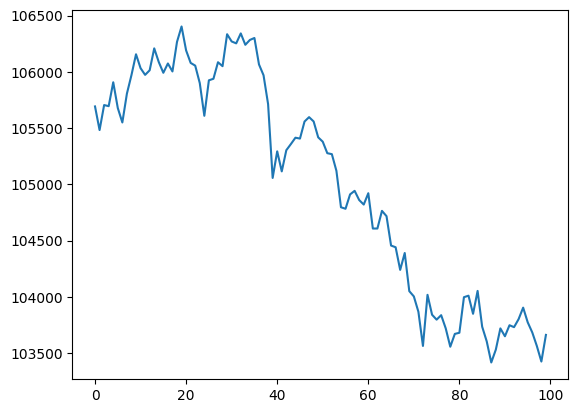

In [22]:
df_candles["fechamento"].plot()